In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.single_transformations.single_direction_speedfree_transformation import SingleDirectionSpeedFreeTransformation
from project_ssms.feature_funcs import feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import k_step_prediction_for_grid_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

import joblib

# data

In [3]:
trajs_all = joblib.load("trajs_all")

In [4]:
trajs = trajs_all[36000*0:36000*1]

In [5]:
f_trajs = filter_traj_by_speed(trajs, q1=0.9, q2=0.9)

In [6]:
arena_xmin = 10
arena_xmax = 320
arena_ymin = -10
arena_ymax = 390

In [7]:
# make 3 by 3 grid world
x_grid_gap = (arena_xmax - arena_xmin) / 3
y_grid_gap = (arena_ymax - arena_ymin) / 3

x_grids = [arena_xmin + i * x_grid_gap for i in range(4)]
y_grids = [arena_ymin + i * y_grid_gap for i in range(4)]

In [8]:
bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])

In [9]:
bounds

array([[ 10, 320],
       [-10, 390],
       [ 10, 320],
       [-10, 390]])

In [10]:
CORNERS = torch.tensor([[10, -10], [10, 390], [320, -10], [320, 390]], dtype=torch.float64)

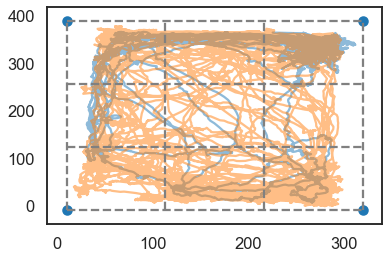

In [11]:
plot_2_mice(trajs, alpha=0.5)
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')


In [12]:
data = torch.tensor(trajs, dtype=torch.float64)

# model

In [13]:
torch.manual_seed(0)
np.random.seed(0)

D = 4
K = 2
M = 0

Df = 4

f_corner_vec_func = lambda s: feature_direction_vec(s, CORNERS)

bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])


tran = GridTransformation(K=K, D=D, x_grids=x_grids, y_grids=y_grids, single_transformation="direction_speedfree",
                          Df=Df, feature_vec_func=f_corner_vec_func, acc_factor=10)

# compute memories
masks_a, masks_b = tran.get_masks(data[:-1])
feature_vecs_a = f_corner_vec_func(data[:-1, 0:2])
feature_vecs_b = f_corner_vec_func(data[:-1, 2:4])

m_kwargs_a = dict(feature_vecs=feature_vecs_a)
m_kwargs_b = dict(feature_vecs=feature_vecs_b)

obs = ARTruncatedNormalObservation(K=K, D=D, M=M, lags=1, bounds=bounds, transformation=tran)

# model
model = HMM(K=K, D=D, M=M, observation=obs)


In [14]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [15]:
log_prob = model.log_likelihood(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

In [16]:
log_prob

tensor(-1890333.1291, dtype=torch.float64, grad_fn=<AddBackward0>)

# training

In [17]:
##################### training ############################

num_iters = 8000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 7990 loss 231988.40: 100%|██████████| 8000/8000 [1:16:04<00:00,  2.37it/s]


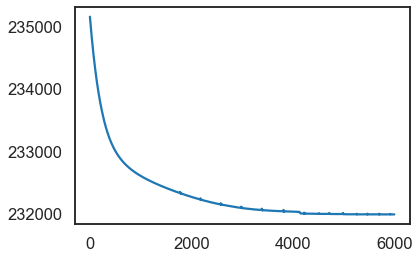

In [21]:
plt.plot(losses[2000:])

In [22]:
print("inferiring most likely states...")
z = model.most_likely_states(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

inferiring most likely states...


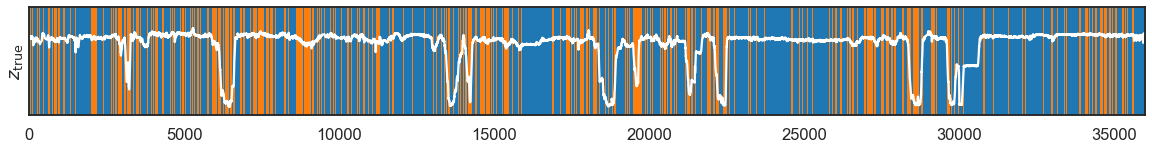

In [36]:
plot_z(z, ylim=(0, 390))

plt.plot(data[:,0].numpy(), color='white')


In [24]:
print("0 step prediction")
x_predict = k_step_prediction_for_grid_model(model, z, data, memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

0 step prediction


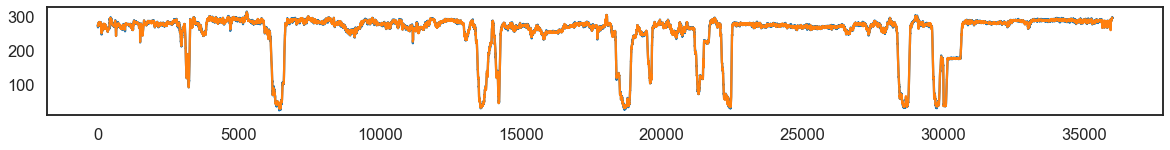

In [25]:
plt.figure(figsize=(20,2))
plt.plot(x_predict[:,0])
plt.plot(data[:,0].numpy())

In [29]:
np.average(np.abs(x_predict-data.numpy()), axis=0)

array([1.22200065, 1.24136208, 1.80072558, 1.90718905])

# sample

In [26]:
sample_z, sample_x = model.sample(36000)

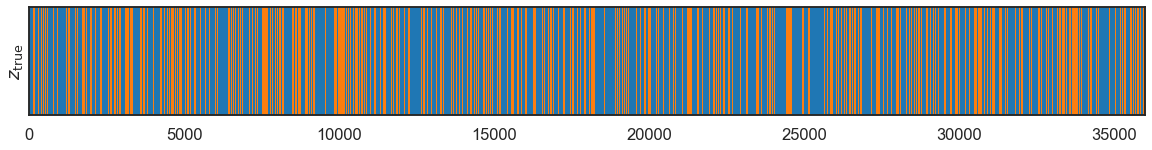

In [27]:
plot_z(sample_z)

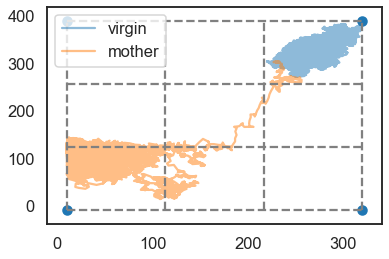

In [33]:
plot_2_mice(sample_x, alpha=0.5)
plt.legend()
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

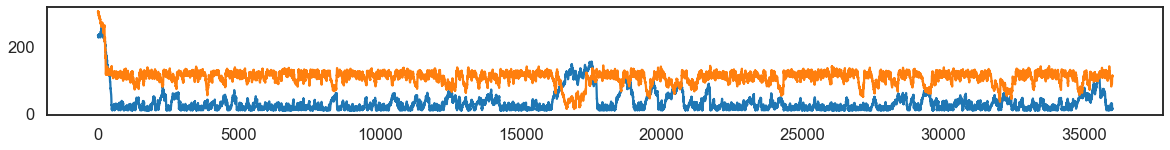

In [34]:
plt.figure(figsize=(20,2))

plt.plot(sample_x[:,2])
plt.plot(sample_x[:,3])

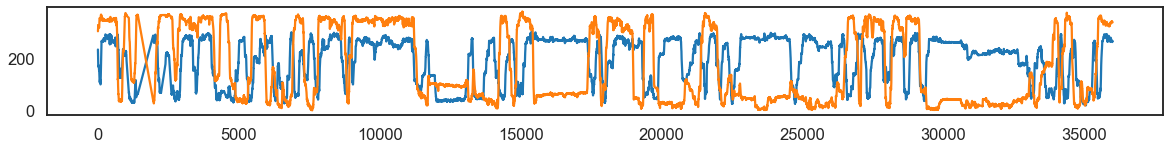

In [35]:
plt.figure(figsize=(20,2))

plt.plot(data[:,2].numpy())
plt.plot(data[:,3].numpy())